#Στοιχεία ομάδας


###Αριθμός ομάδας: 43 
Datasets: S05, B05

###Μέλη:
Επίθετο | Όνομα | Α.Μ.
---|---|---
Κορακοβούνης|Δημήτριος|03116692
Αναγνωστόπουλος|Θεόδωρος|03116066

<br>
</br>

#Βοηθητικός κώδικας εργαστηρίου

In [ ]:
!pip install pyyaml h5py
!pip install --upgrade joblib
!pip install -U keras-tuner

Requirement already up-to-date: joblib in /usr/local/lib/python3.7/dist-packages (1.0.1)
Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.7/dist-packages (1.0.2)


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import joblib

In [ ]:
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

# select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
def select_classes_number(classes_number = 20):
  cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
  cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
  cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
  cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
  if classes_number == 20:
    return cifar100_20_classes_url
  elif classes_number == 40:
    return cifar100_40_classes_url
  elif classes_number == 60:
    return cifar100_60_classes_url
  elif classes_number == 80:
    return cifar100_80_classes_url
  else:
    return -1

In [ ]:
# load the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

#Αριθμός της ομάδας
team_seed = 43

cifar100_classes_url = select_classes_number(80)

In [ ]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))


CLASSES_NUM=len(our_classes)

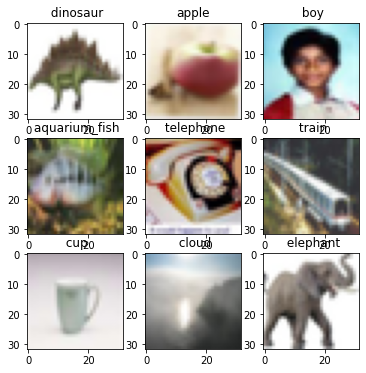

In [ ]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

def _input_fn(x,y, BATCH_SIZE):
  ds = tf.data.Dataset.from_tensor_slices((x,y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  #ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object

# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate

def train_model(model, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps)
  return(history)

###Γραφικές παραστάσεις

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history, duration = 0):
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves')
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history['loss'], color='blue', label='train')
	plt.plot(history['val_loss'], color='orange', label='val')
	plt.legend(loc='upper right')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history['accuracy'], color='blue', label='train')
	plt.plot(history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='lower right')
	return plt
 
# print test set evaluation metrics
def model_evaluation(model, evaluation_steps, test_ds):
	print('\nTest set evaluation metrics')
	loss0,accuracy0 = model.evaluate(test_ds, steps = evaluation_steps)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history = 0, evaluation_steps = 10, old = False, test_ds = test_ds):
  if old:
    [history, duration] = joblib.load(path+model+".pkl")
    print("Train Time: ",duration,"\n")
    model = tf.keras.models.load_model(path+model)
    plt = summarize_diagnostics(history)
  else:
    plt = summarize_diagnostics(history.history)
  plt.show()
  model_evaluation(model, evaluation_steps, test_ds)

# Βελτίωση μοντέλων βάση πειραματικών δεδομένων

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Neural 3h/"
def save_model(model, history, duration, model_name):
  model.save(path+sub_path+model_name)
  data = [history.history, duration]
  joblib.dump(data,path+sub_path+model_name+".pkl")

### sub_path is declared later and changes in every added optimization

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sub_path = "unoptimized/"

In [ ]:
# function to modify pre-trained models
Dropout = False

def load_model(model):
  if model == "DenseNet 201":
    return tf.keras.applications.DenseNet201(input_shape=(32,32,3), include_top=False, weights='imagenet'), True
  if model == "Inception-ResNet V2":
    return tf.keras.applications.InceptionResNetV2(input_shape=(75,75,3), include_top=False, weights='imagenet'), True
  if model == "Inception V3":
    return tf.keras.applications.InceptionV3(input_shape=(75,75,3), include_top=False, weights='imagenet'), True
  if model == "MobileNet v1":
    return tf.keras.applications.MobileNetv1(input_shape=(32,32,3), include_top=False, weights='imagenet'), True
  if model == "MobileNet v2":
    return tf.keras.applications.MobileNetV2(input_shape=(32,32,3), include_top=False, weights='imagenet'), True
  if model == "NASNet-A":
    return tf.keras.applications.NASNetA(input_shape=(32,32,3), include_top=False, weights='imagenet'), True
  if model == "ResNet":
    return tf.keras.applications.ResNet(input_shape=(32,32,3), include_top=False, weights='imagenet'), True
  if model == "ResNet v2":
    return tf.keras.applications.ResNet152V2(input_shape=(32,32,3), include_top=False, weights='imagenet'), True
  if model == "VGG16":
    return tf.keras.applications.VGG16(input_shape=(32,32,3), include_top=False, weights='imagenet'), True
  if model == "VGG19":
    return tf.keras.applications.VGG19(input_shape=(32,32,3), include_top=False, weights='imagenet'), True
  if model == "Xception":
    return tf.keras.applications.Xception(input_shape=(71,71,3), include_top=False, weights='imagenet'), True
  if model == "model_1":
    return simple_model(True, Dropout), False
  if model == "model_2":
    return another_simple_model(True, Dropout), False
  if model == "model_3":
    return complex_model(True, Dropout), False


def transfer_learn(model):
  model, transfered = load_model(model)
  if not transfered:
    return model
  model.trainable=True
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  prediction_layer = tf.keras.layers.Dense(100,activation='softmax')
  model = tf.keras.Sequential([model, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  return model


def train_and_print(model_name):
  if model_name == "Inception-ResNet V2" or model_name == "Inception V3":
    train_resized = tf.image.resize(x_train, (75, 75))
    val_resized = tf.image.resize(x_val, (75, 75))
    test_resized = tf.image.resize(x_test, (75, 75))
  elif model_name == "Xception":
    train_resized = tf.image.resize(x_train, (71, 71))
    val_resized = tf.image.resize(x_val, (71, 71))
    test_resized = tf.image.resize(x_test, (71, 71))   
  else:
    train_resized = tf.image.resize(x_train, (32, 32))
    val_resized = tf.image.resize(x_val, (32, 32))
    test_resized = tf.image.resize(x_test, (32, 32))

  train_ds =_input_fn(train_resized,y_train, BATCH_SIZE) 
  validation_ds =_input_fn(val_resized,y_val, BATCH_SIZE)
  test_ds =_input_fn(test_resized,y_test, BATCH_SIZE)

  model = transfer_learn(model_name)
  start = time.time()
  model_history =  model.fit(train_ds, epochs=50, steps_per_epoch=30, validation_data=validation_ds, validation_steps=10)
  duration = time.time() - start
  model_report(model, model_history, test_ds = test_ds)
  print("Train Time: ",duration)
  save_model(model, model_history, duration, model_name)

###Μοντέλα from scratch

In [ ]:
def simple_model(summary, Dropout = False):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  if Dropout:
    model.add(layers.Dropout(rate = 0.25))
  model.add(layers.Dense(100,activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:

def another_simple_model(summary, Dropout = False):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (5, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  if Dropout:
    model.add(layers.Dropout(rate = 0.25))
  model.add(layers.Dense(100, activation='softmax'))
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [ ]:
def complex_model(summary, Dropout = False):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (5, 5), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(100, activation='relu'))
  if Dropout:
    model.add(layers.Dropout(rate = 0.25))
  model.add(layers.Dense(100, activation='softmax'))
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,decay=1e-6,epsilon = 0.001), loss = tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

######Scratch model 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

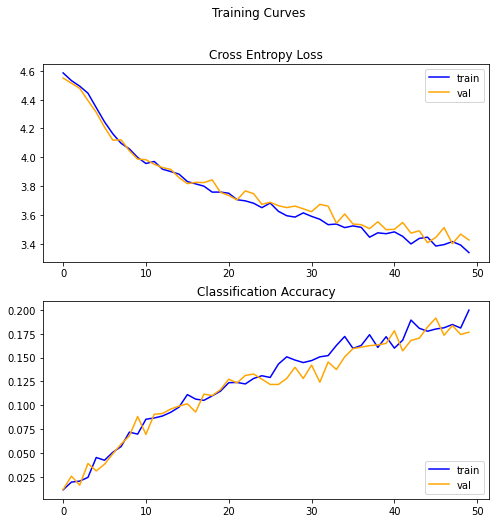


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 3.3947 - accuracy: 0.1914
loss: 3.39
accuracy: 0.19
Train Time:  30.108410596847534
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/unoptimized/model_1/assets


In [ ]:
train_and_print("model_1")

######Scratch model 2

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 13, 64)        30784     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 4, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

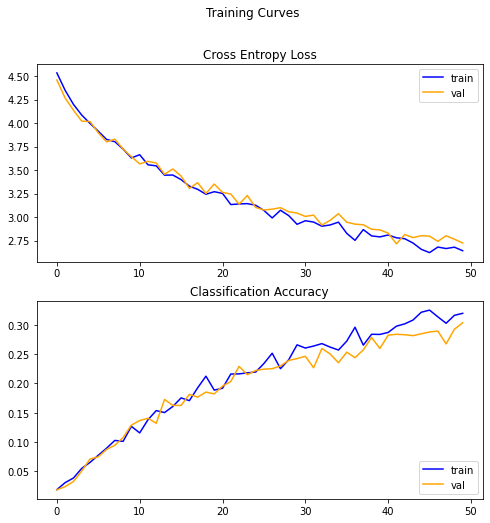


Test set evaluation metrics
10/10 [==============================] - 0s 4ms/step - loss: 2.6848 - accuracy: 0.3141
loss: 2.68
accuracy: 0.31
Train Time:  23.205267906188965
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/unoptimized/model_2/assets


In [ ]:
train_and_print("model_2")

######Scratch model 3

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 128)      

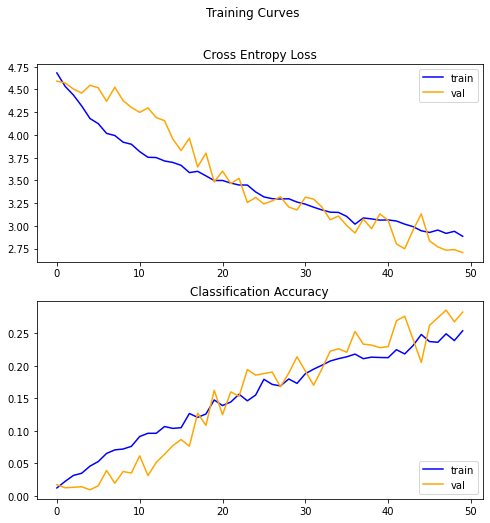


Test set evaluation metrics
10/10 [==============================] - 0s 6ms/step - loss: 2.6384 - accuracy: 0.3172
loss: 2.64
accuracy: 0.32
Train Time:  33.200377464294434
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/unoptimized/model_3/assets


In [ ]:
train_and_print("model_3")

###Μοντέλα με Transfer Learning

####DenseNet

74842112/74836368 [==============================] - 0s 0us/step
Epoch 1/50
30/30 [==============================] - 26s 202ms/step - loss: 4.7958 - accuracy: 0.0148 - val_loss: 4.5418 - val_accuracy: 0.0227
Epoch 2/50
30/30 [==============================] - 3s 101ms/step - loss: 4.3934 - accuracy: 0.0497 - val_loss: 4.4071 - val_accuracy: 0.0508
Epoch 3/50
30/30 [==============================] - 3s 101ms/step - loss: 4.1251 - accuracy: 0.1129 - val_loss: 4.2654 - val_accuracy: 0.0953
Epoch 4/50
30/30 [==============================] - 3s 101ms/step - loss: 3.8306 - accuracy: 0.1805 - val_loss: 4.0683 - val_accuracy: 0.1367
Epoch 5/50
30/30 [==============================] - 3s 101ms/step - loss: 3.6039 - accuracy: 0.2041 - val_loss: 3.9206 - val_accuracy: 0.1961
Epoch 6/50
30/30 [==============================] - 3s 102ms/step - loss: 3.3619 - accuracy: 0.2451 - val_loss: 3.6593 - val_accuracy: 0.2445
Epoch 7/50
30/30 [==============================] - 3s 101ms/step - loss: 3.1684 -

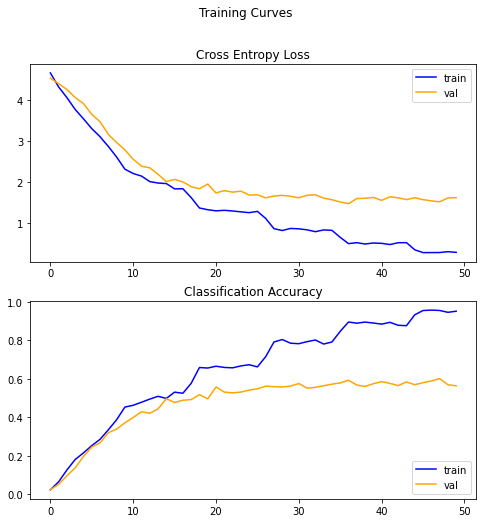


Test set evaluation metrics
10/10 [==============================] - 1s 30ms/step - loss: 1.6274 - accuracy: 0.5672
loss: 1.63
accuracy: 0.57
Train Time:  176.8087341785431
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/unoptimized/DenseNet 201/assets


In [ ]:
train_and_print("DenseNet 201")

####Inception-ResNet V2

Epoch 1/50
30/30 [==============================] - 35s 385ms/step - loss: 4.6784 - accuracy: 0.0222 - val_loss: 4.6452 - val_accuracy: 0.0383
Epoch 2/50
30/30 [==============================] - 12s 407ms/step - loss: 4.2695 - accuracy: 0.0808 - val_loss: 4.3332 - val_accuracy: 0.0672
Epoch 3/50
30/30 [==============================] - 12s 408ms/step - loss: 3.8694 - accuracy: 0.1671 - val_loss: 3.9252 - val_accuracy: 0.1727
Epoch 4/50
30/30 [==============================] - 12s 406ms/step - loss: 3.4807 - accuracy: 0.2452 - val_loss: 3.5636 - val_accuracy: 0.2656
Epoch 5/50
30/30 [==============================] - 12s 402ms/step - loss: 3.0835 - accuracy: 0.3113 - val_loss: 3.0871 - val_accuracy: 0.3336
Epoch 6/50
30/30 [==============================] - 12s 404ms/step - loss: 2.6883 - accuracy: 0.3981 - val_loss: 2.7213 - val_accuracy: 0.4219
Epoch 7/50
30/30 [==============================] - 12s 401ms/step - loss: 2.4147 - accuracy: 0.4393 - val_loss: 2.4597 - val_accuracy: 0.4211

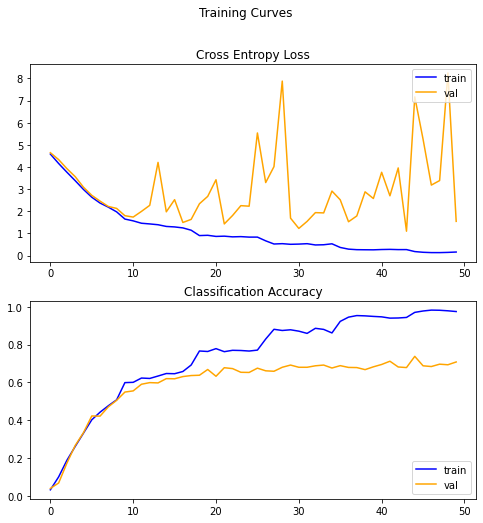


Test set evaluation metrics
10/10 [==============================] - 2s 73ms/step - loss: 3.0425 - accuracy: 0.7047
loss: 3.04
accuracy: 0.70
Train Time:  563.1049425601959
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/unoptimized/Inception-ResNet V2/assets


In [ ]:
train_and_print("Inception-ResNet V2")

####Inception V3

Epoch 1/50
30/30 [==============================] - 21s 209ms/step - loss: 4.6693 - accuracy: 0.0147 - val_loss: 4.5612 - val_accuracy: 0.0273
Epoch 2/50
30/30 [==============================] - 5s 167ms/step - loss: 4.4623 - accuracy: 0.0343 - val_loss: 4.4594 - val_accuracy: 0.0281
Epoch 3/50
30/30 [==============================] - 7s 253ms/step - loss: 4.2989 - accuracy: 0.0651 - val_loss: 4.2830 - val_accuracy: 0.0891
Epoch 4/50
30/30 [==============================] - 8s 275ms/step - loss: 4.0093 - accuracy: 0.1255 - val_loss: 4.0495 - val_accuracy: 0.1242
Epoch 5/50
30/30 [==============================] - 8s 277ms/step - loss: 3.7230 - accuracy: 0.1702 - val_loss: 3.8378 - val_accuracy: 0.1820
Epoch 6/50
30/30 [==============================] - 8s 271ms/step - loss: 3.3744 - accuracy: 0.2402 - val_loss: 3.5127 - val_accuracy: 0.2562
Epoch 7/50
30/30 [==============================] - 8s 272ms/step - loss: 3.0744 - accuracy: 0.2932 - val_loss: 3.1866 - val_accuracy: 0.3227
Epoch

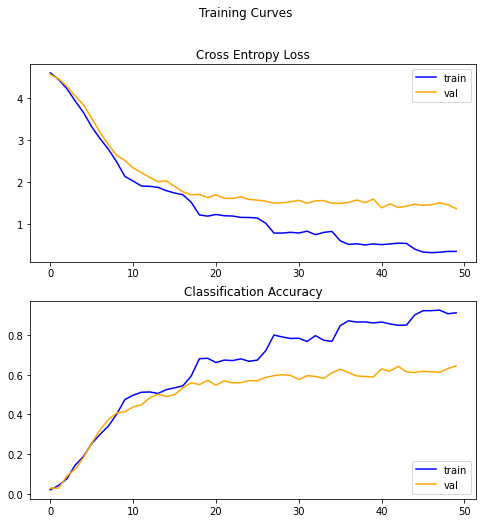


Test set evaluation metrics
10/10 [==============================] - 2s 41ms/step - loss: 1.4677 - accuracy: 0.6102
loss: 1.47
accuracy: 0.61
Train Time:  381.4331376552582
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/unoptimized/Inception V3/assets


In [ ]:
train_and_print("Inception V3")

####MobileNet v2

9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/50
30/30 [==============================] - 6s 64ms/step - loss: 5.5238 - accuracy: 0.0119 - val_loss: 4.6268 - val_accuracy: 0.0063
Epoch 2/50
30/30 [==============================] - 1s 34ms/step - loss: 5.1708 - accuracy: 0.0216 - val_loss: 4.6237 - val_accuracy: 0.0047
Epoch 3/50
30/30 [==============================] - 1s 33ms/step - loss: 4.9220 - accuracy: 0.0225 - val_loss: 4.6169 - val_accuracy: 0.0086
Epoch 4/50
30/30 [==============================] - 1s 30ms/step - loss: 4.7746 - accuracy: 0.0313 - val_loss: 4.6259 - val_accuracy: 0.0086
Epoch 5/50
30/30 [==============================] - 1s 29ms/step - loss: 4.6513 - accuracy: 0.0364 - val_loss: 4.6305 - val_accuracy: 0.0039
Epoch 6/50
30/30 [==============================] - 1s 30ms/step - loss: 4.5336 - accuracy: 0.0442 - val_loss: 4.6536 - val_accuracy: 0.0133
Epoch 7/50
30/30 [==============================] - 1s 30ms/step - loss: 4.4595 - accuracy:

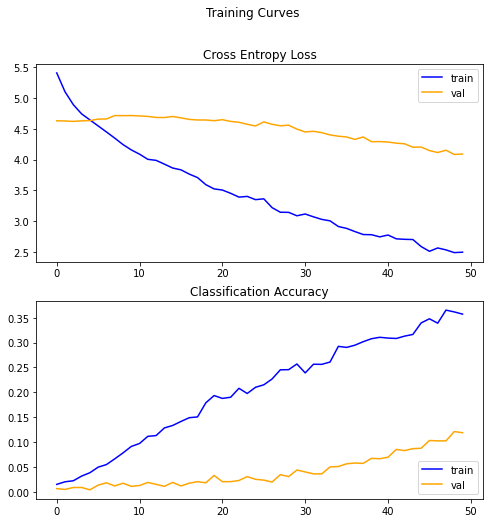


Test set evaluation metrics
10/10 [==============================] - 0s 9ms/step - loss: 4.0952 - accuracy: 0.1227
loss: 4.10
accuracy: 0.12
Train Time:  51.2467474937439
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/unoptimized/MobileNet v2/assets


In [ ]:
train_and_print("MobileNet v2")

####ResNet v2

In [ ]:
train_and_print("ResNet v2")

####VGG16

Epoch 1/50
30/30 [==============================] - 3s 75ms/step - loss: 4.6128 - accuracy: 0.0231 - val_loss: 4.0109 - val_accuracy: 0.0922
Epoch 2/50
30/30 [==============================] - 2s 65ms/step - loss: 3.8441 - accuracy: 0.1206 - val_loss: 3.2472 - val_accuracy: 0.2133
Epoch 3/50
30/30 [==============================] - 2s 65ms/step - loss: 3.2238 - accuracy: 0.2093 - val_loss: 2.8906 - val_accuracy: 0.2703
Epoch 4/50
30/30 [==============================] - 2s 66ms/step - loss: 2.8395 - accuracy: 0.2886 - val_loss: 2.6787 - val_accuracy: 0.3000
Epoch 5/50
30/30 [==============================] - 2s 66ms/step - loss: 2.6378 - accuracy: 0.3296 - val_loss: 2.5359 - val_accuracy: 0.3500
Epoch 6/50
30/30 [==============================] - 2s 67ms/step - loss: 2.4437 - accuracy: 0.3620 - val_loss: 2.3018 - val_accuracy: 0.3938
Epoch 7/50
30/30 [==============================] - 2s 67ms/step - loss: 2.2836 - accuracy: 0.4010 - val_loss: 2.2641 - val_accuracy: 0.3906
Epoch 8/50
30

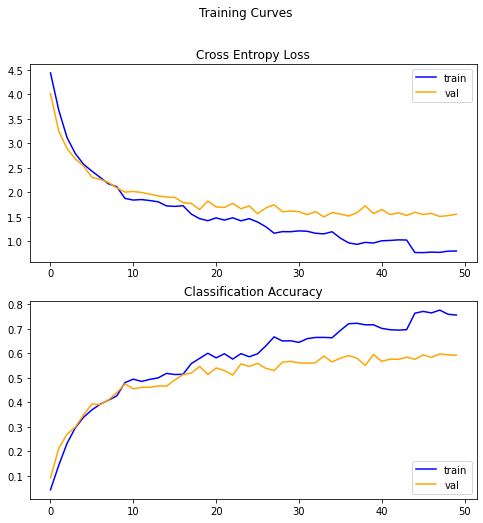


Test set evaluation metrics
10/10 [==============================] - 0s 16ms/step - loss: 1.5723 - accuracy: 0.5742
loss: 1.57
accuracy: 0.57
Train Time:  101.7903938293457
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/unoptimized/VGG16/assets


In [ ]:
train_and_print("VGG16")

####VGG19

Epoch 1/50
30/30 [==============================] - 4s 90ms/step - loss: 4.6903 - accuracy: 0.0156 - val_loss: 4.2818 - val_accuracy: 0.0547
Epoch 2/50
30/30 [==============================] - 2s 83ms/step - loss: 4.1372 - accuracy: 0.0789 - val_loss: 3.7092 - val_accuracy: 0.1383
Epoch 3/50
30/30 [==============================] - 2s 81ms/step - loss: 3.5543 - accuracy: 0.1668 - val_loss: 3.2784 - val_accuracy: 0.1961
Epoch 4/50
30/30 [==============================] - 2s 82ms/step - loss: 3.2289 - accuracy: 0.2099 - val_loss: 2.8844 - val_accuracy: 0.2688
Epoch 5/50
30/30 [==============================] - 2s 82ms/step - loss: 2.8409 - accuracy: 0.2743 - val_loss: 2.7253 - val_accuracy: 0.2984
Epoch 6/50
30/30 [==============================] - 2s 82ms/step - loss: 2.7194 - accuracy: 0.3181 - val_loss: 2.5852 - val_accuracy: 0.3320
Epoch 7/50
30/30 [==============================] - 2s 82ms/step - loss: 2.5099 - accuracy: 0.3385 - val_loss: 2.5325 - val_accuracy: 0.3266
Epoch 8/50
30

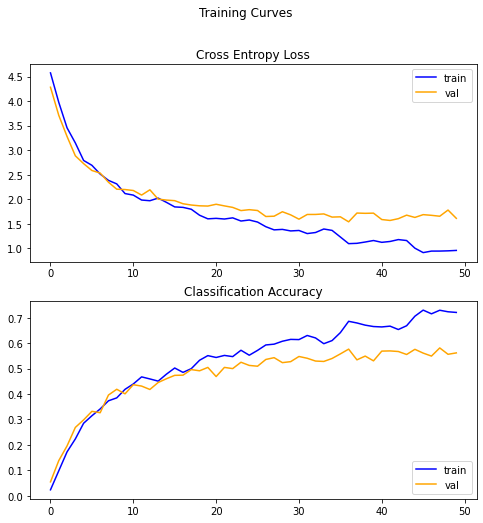


Test set evaluation metrics
10/10 [==============================] - 0s 19ms/step - loss: 1.5298 - accuracy: 0.5742
loss: 1.53
accuracy: 0.57
Train Time:  124.0711452960968
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/unoptimized/VGG19/assets


In [ ]:
train_and_print("VGG19")

####Xception

Epoch 1/50
30/30 [==============================] - 22s 343ms/step - loss: 4.6013 - accuracy: 0.0147 - val_loss: 4.4344 - val_accuracy: 0.0562
Epoch 2/50
30/30 [==============================] - 9s 317ms/step - loss: 4.3420 - accuracy: 0.0691 - val_loss: 4.0306 - val_accuracy: 0.1336
Epoch 3/50
30/30 [==============================] - 11s 369ms/step - loss: 3.9357 - accuracy: 0.1732 - val_loss: 3.6612 - val_accuracy: 0.2117
Epoch 4/50
30/30 [==============================] - 11s 372ms/step - loss: 3.5982 - accuracy: 0.2310 - val_loss: 3.3264 - val_accuracy: 0.2781
Epoch 5/50
30/30 [==============================] - 11s 370ms/step - loss: 3.3286 - accuracy: 0.2997 - val_loss: 2.9953 - val_accuracy: 0.3383
Epoch 6/50
30/30 [==============================] - 11s 373ms/step - loss: 3.0203 - accuracy: 0.3619 - val_loss: 2.7267 - val_accuracy: 0.3781
Epoch 7/50
30/30 [==============================] - 11s 377ms/step - loss: 2.7611 - accuracy: 0.4078 - val_loss: 2.4368 - val_accuracy: 0.4344


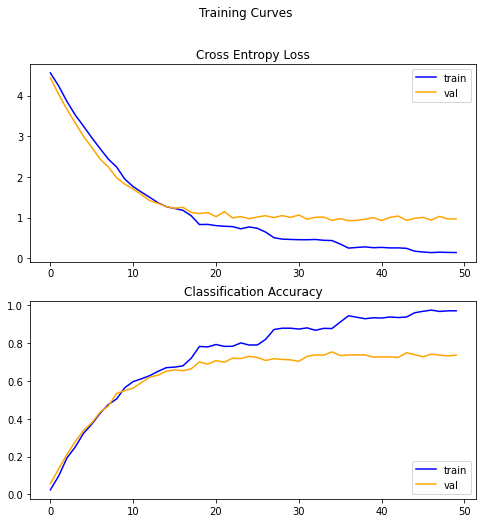


Test set evaluation metrics
10/10 [==============================] - 2s 72ms/step - loss: 0.8838 - accuracy: 0.7578
loss: 0.88
accuracy: 0.76
Train Time:  594.0778136253357
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/unoptimized/Xception/assets


In [ ]:
train_and_print("Xception")

#Optimizers


##Hardware optimizations - Time and Memory

Use of tfrecords, mapping, caching and prefetching
<br>
<br>
<br>


In [ ]:
sub_path = "hardware_opt/"


import os


def augment75(image, label):
    return tf.image.resize(image, (75, 75)), label

def augment71(image, label):
    return tf.image.resize(image, (71, 71)), label

def write_tfrecords(x, y, filename):
    writer = tf.io.TFRecordWriter(filename)
    for image, label in zip(x, y):
        image = np.around(255*image)
        image = image.astype(np.int8)
        example = tf.train.Example(features=tf.train.Features(
            feature={
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(image)])),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            }))
        writer.write(example.SerializeToString())

write_tfrecords(x_val, y_val, 'val.tfrecords')

write_tfrecords(x_test, y_test, 'test.tfrecords')

write_tfrecords(x_train, y_train, 'train.tfrecords')

image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

def _parse_image_function(example_proto):
    features = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.io.decode_raw(features['image'], tf.uint8)
    image.set_shape([3 * 32 * 32])
    image = tf.reshape(image, [32, 32, 3])

    label = tf.cast(features['label'], tf.int64)

    return image, label

def read_dataset(epochs, batch_size, filename, model, augmentation = False):

    filenames = [os.path.join( filename + '.tfrecords')]
    dataset = tf.data.TFRecordDataset(filenames)

    dataset = dataset.map(_parse_image_function, num_parallel_calls=AUTOTUNE).cache()
    if model == "Inception-ResNet V2" or model == "Inception V3":
        dataset = dataset.map(augment75).cache()
    elif model == "Xception":
        dataset = dataset.map(augment71).cache()
    dataset = dataset.repeat(epochs)
    dataset = dataset.shuffle(buffer_size=10 * batch_size)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset


def train2(model_name, train_ds, validation_ds, test_ds):
  
  model = transfer_learn(model_name)
  start = time.time()
  model_history =  model.fit(train_ds, epochs=50, steps_per_epoch=30, validation_data=validation_ds, validation_steps=10)
  duration = time.time() - start
  model_report(model, model_history, test_ds = test_ds)
  print("Train Time: ",duration)
  save_model(model, model_history, duration, model_name)

def train_and_print_hardware(model):
  train_ds = read_dataset(50, BATCH_SIZE, 'train',model)
  validation_ds = read_dataset(50, BATCH_SIZE, 'val',model)
  test_ds = read_dataset(50, BATCH_SIZE, 'test',model)

  train2(model, train_ds, validation_ds, test_ds)

###Μοντέλα from scratch

####Scratch model 1

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

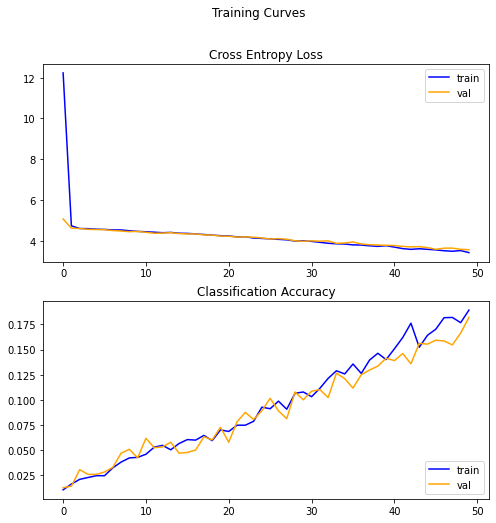


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 3.5845 - accuracy: 0.1633
loss: 3.58
accuracy: 0.16
Train Time:  15.993115663528442
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/hardware_opt/model_1/assets


In [ ]:
train_and_print_hardware("model_1")

####Scratch model 2

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 13, 64)        30784     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 6, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 4, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

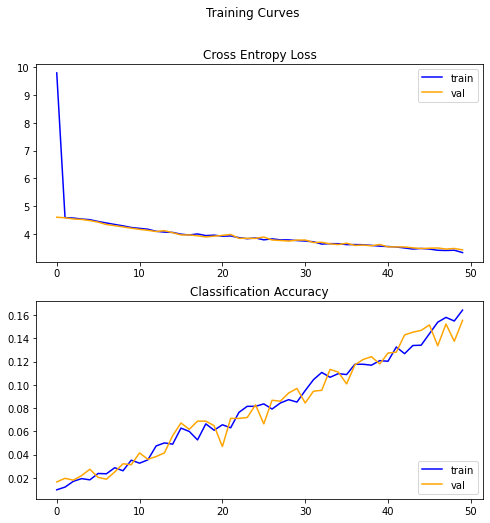


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 3.4433 - accuracy: 0.1570
loss: 3.44
accuracy: 0.16
Train Time:  15.120932579040527
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/hardware_opt/model_2/assets


In [ ]:
train_and_print_hardware("model_2")

####Scratch model 3


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 128)      

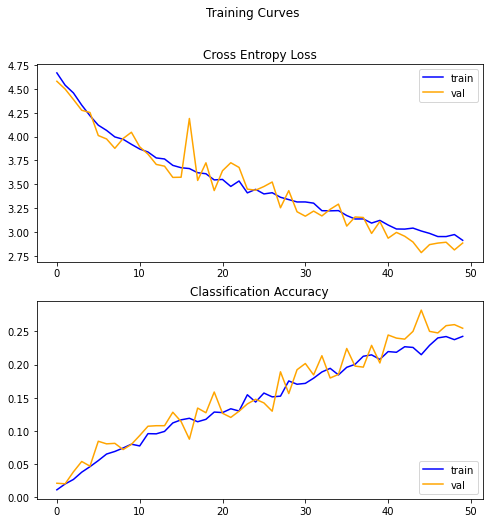


Test set evaluation metrics
10/10 [==============================] - 0s 9ms/step - loss: 2.9124 - accuracy: 0.2641
loss: 2.91
accuracy: 0.26
Train Time:  26.24866271018982
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/hardware_opt/model_3/assets


In [ ]:
train_and_print_hardware("model_3")

###Μοντέλα με Transfer Learning

####DenseNet

Epoch 1/50
30/30 [==============================] - 25s 193ms/step - loss: 4.8021 - accuracy: 0.0096 - val_loss: 4.5779 - val_accuracy: 0.0195
Epoch 2/50
30/30 [==============================] - 3s 98ms/step - loss: 4.4140 - accuracy: 0.0497 - val_loss: 4.2915 - val_accuracy: 0.0695
Epoch 3/50
30/30 [==============================] - 3s 98ms/step - loss: 4.1759 - accuracy: 0.1088 - val_loss: 4.1043 - val_accuracy: 0.1430
Epoch 4/50
30/30 [==============================] - 3s 97ms/step - loss: 3.8552 - accuracy: 0.1681 - val_loss: 3.8840 - val_accuracy: 0.2023
Epoch 5/50
30/30 [==============================] - 3s 98ms/step - loss: 3.6042 - accuracy: 0.1983 - val_loss: 3.7309 - val_accuracy: 0.2367
Epoch 6/50
30/30 [==============================] - 3s 100ms/step - loss: 3.2706 - accuracy: 0.2684 - val_loss: 3.4993 - val_accuracy: 0.2703
Epoch 7/50
30/30 [==============================] - 3s 98ms/step - loss: 3.0780 - accuracy: 0.2995 - val_loss: 3.2664 - val_accuracy: 0.3078
Epoch 8/50

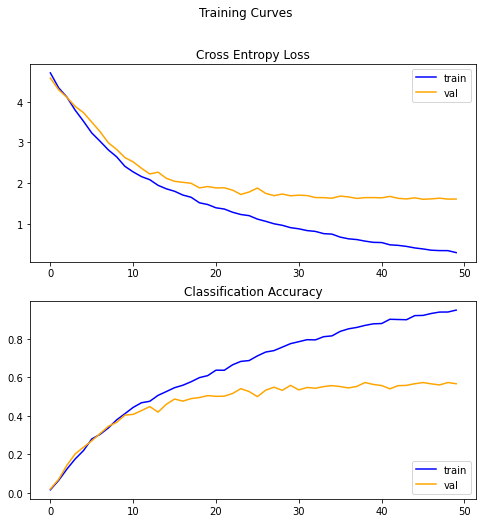


Test set evaluation metrics
10/10 [==============================] - 0s 29ms/step - loss: 1.6604 - accuracy: 0.5656
loss: 1.66
accuracy: 0.57
Train Time:  165.97245144844055
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/hardware_opt/DenseNet 201/assets


In [ ]:
train_and_print_hardware("DenseNet 201")

####Inception-ResNet V2

Epoch 1/50
30/30 [==============================] - 30s 340ms/step - loss: 4.7247 - accuracy: 0.0176 - val_loss: 4.8700 - val_accuracy: 0.0219
Epoch 2/50
30/30 [==============================] - 7s 244ms/step - loss: 4.3361 - accuracy: 0.0621 - val_loss: 4.2311 - val_accuracy: 0.0859
Epoch 3/50
30/30 [==============================] - 7s 248ms/step - loss: 3.9624 - accuracy: 0.1255 - val_loss: 3.8540 - val_accuracy: 0.1609
Epoch 4/50
30/30 [==============================] - 7s 249ms/step - loss: 3.6009 - accuracy: 0.2112 - val_loss: 3.4727 - val_accuracy: 0.2734
Epoch 5/50
30/30 [==============================] - 8s 253ms/step - loss: 3.2237 - accuracy: 0.2713 - val_loss: 3.1034 - val_accuracy: 0.3406
Epoch 6/50
30/30 [==============================] - 8s 255ms/step - loss: 2.9036 - accuracy: 0.3449 - val_loss: 2.7716 - val_accuracy: 0.3828
Epoch 7/50
30/30 [==============================] - 8s 256ms/step - loss: 2.6135 - accuracy: 0.3910 - val_loss: 2.5250 - val_accuracy: 0.4227
Epoch

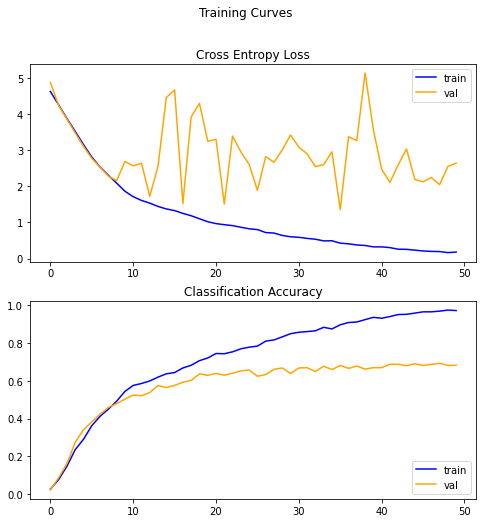


Test set evaluation metrics
10/10 [==============================] - 1s 66ms/step - loss: 2.7977 - accuracy: 0.6828
loss: 2.80
accuracy: 0.68
Train Time:  400.6844115257263
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/hardware_opt/Inception-ResNet V2/assets


In [ ]:
train_and_print_hardware("Inception-ResNet V2")

####Inception V3

Epoch 1/50
30/30 [==============================] - 13s 159ms/step - loss: 4.6232 - accuracy: 0.0189 - val_loss: 4.6692 - val_accuracy: 0.0102
Epoch 2/50
30/30 [==============================] - 4s 119ms/step - loss: 4.4563 - accuracy: 0.0425 - val_loss: 4.4961 - val_accuracy: 0.0328
Epoch 3/50
30/30 [==============================] - 4s 120ms/step - loss: 4.1657 - accuracy: 0.1053 - val_loss: 4.2880 - val_accuracy: 0.0727
Epoch 4/50
30/30 [==============================] - 4s 121ms/step - loss: 3.9124 - accuracy: 0.1469 - val_loss: 4.0185 - val_accuracy: 0.1242
Epoch 5/50
30/30 [==============================] - 4s 120ms/step - loss: 3.6228 - accuracy: 0.1851 - val_loss: 3.7311 - val_accuracy: 0.2125
Epoch 6/50
30/30 [==============================] - 4s 121ms/step - loss: 3.2754 - accuracy: 0.2690 - val_loss: 3.3987 - val_accuracy: 0.2664
Epoch 7/50
30/30 [==============================] - 4s 122ms/step - loss: 2.9810 - accuracy: 0.3054 - val_loss: 3.1162 - val_accuracy: 0.3109
Epoch

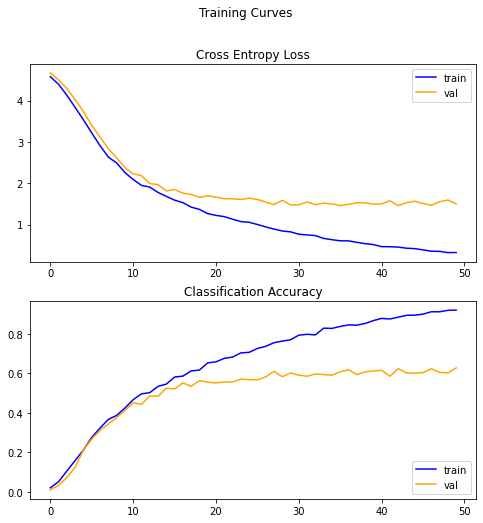


Test set evaluation metrics
10/10 [==============================] - 0s 31ms/step - loss: 1.4319 - accuracy: 0.6164
loss: 1.43
accuracy: 0.62
Train Time:  192.89200043678284
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/hardware_opt/Inception V3/assets


In [ ]:
train_and_print_hardware("Inception V3")

####MobileNet v2

Epoch 1/50
30/30 [==============================] - 5s 50ms/step - loss: 5.5944 - accuracy: 0.0087 - val_loss: 4.6217 - val_accuracy: 0.0180
Epoch 2/50
30/30 [==============================] - 1s 32ms/step - loss: 5.1458 - accuracy: 0.0147 - val_loss: 4.6276 - val_accuracy: 0.0102
Epoch 3/50
30/30 [==============================] - 1s 30ms/step - loss: 4.9504 - accuracy: 0.0217 - val_loss: 4.6360 - val_accuracy: 0.0164
Epoch 4/50
30/30 [==============================] - 1s 32ms/step - loss: 4.7842 - accuracy: 0.0313 - val_loss: 4.6396 - val_accuracy: 0.0133
Epoch 5/50
30/30 [==============================] - 1s 29ms/step - loss: 4.6353 - accuracy: 0.0346 - val_loss: 4.6423 - val_accuracy: 0.0078
Epoch 6/50
30/30 [==============================] - 1s 26ms/step - loss: 4.5599 - accuracy: 0.0474 - val_loss: 4.6551 - val_accuracy: 0.0094
Epoch 7/50
30/30 [==============================] - 1s 26ms/step - loss: 4.4683 - accuracy: 0.0557 - val_loss: 4.6783 - val_accuracy: 0.0148
Epoch 8/50
30

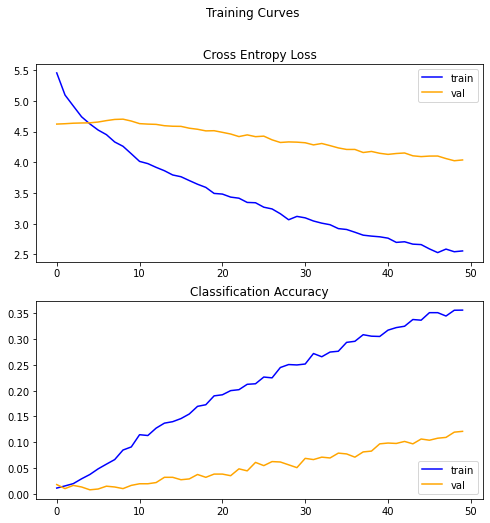


Test set evaluation metrics
10/10 [==============================] - 0s 10ms/step - loss: 4.0574 - accuracy: 0.1102
loss: 4.06
accuracy: 0.11
Train Time:  42.82835364341736
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/hardware_opt/MobileNet v2/assets


In [ ]:
train_and_print_hardware("MobileNet v2")

####ResNet v2

Epoch 1/50
30/30 [==============================] - 22s 230ms/step - loss: 5.3613 - accuracy: 0.0121 - val_loss: 4.9877 - val_accuracy: 0.0078
Epoch 2/50
30/30 [==============================] - 5s 152ms/step - loss: 4.7681 - accuracy: 0.0177 - val_loss: 4.6406 - val_accuracy: 0.0086
Epoch 3/50
30/30 [==============================] - 5s 153ms/step - loss: 4.6405 - accuracy: 0.0149 - val_loss: 4.6005 - val_accuracy: 0.0148
Epoch 4/50
30/30 [==============================] - 5s 154ms/step - loss: 4.5922 - accuracy: 0.0213 - val_loss: 4.5913 - val_accuracy: 0.0133
Epoch 5/50
30/30 [==============================] - 5s 153ms/step - loss: 4.5822 - accuracy: 0.0294 - val_loss: 4.5905 - val_accuracy: 0.0188
Epoch 6/50
30/30 [==============================] - 5s 153ms/step - loss: 4.5247 - accuracy: 0.0395 - val_loss: 4.5740 - val_accuracy: 0.0336
Epoch 7/50
30/30 [==============================] - 5s 154ms/step - loss: 4.4966 - accuracy: 0.0475 - val_loss: 4.5657 - val_accuracy: 0.0352
Epoch

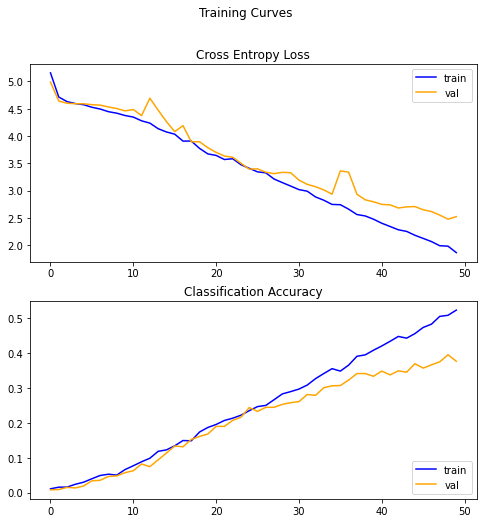


Test set evaluation metrics
10/10 [==============================] - 1s 44ms/step - loss: 2.4580 - accuracy: 0.3945
loss: 2.46
accuracy: 0.39
Train Time:  247.48677778244019
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/hardware_opt/ResNet v2/assets


In [ ]:
train_and_print_hardware("ResNet v2")

####VGG16

Epoch 1/50
30/30 [==============================] - 4s 71ms/step - loss: 14.7866 - accuracy: 0.0150 - val_loss: 4.5964 - val_accuracy: 0.0242
Epoch 2/50
30/30 [==============================] - 2s 61ms/step - loss: 4.5978 - accuracy: 0.0163 - val_loss: 4.5929 - val_accuracy: 0.0180
Epoch 3/50
30/30 [==============================] - 2s 61ms/step - loss: 4.5875 - accuracy: 0.0149 - val_loss: 4.5696 - val_accuracy: 0.0156
Epoch 4/50
30/30 [==============================] - 2s 60ms/step - loss: 4.5754 - accuracy: 0.0214 - val_loss: 4.5565 - val_accuracy: 0.0164
Epoch 5/50
30/30 [==============================] - 2s 61ms/step - loss: 4.5598 - accuracy: 0.0095 - val_loss: 4.5603 - val_accuracy: 0.0102
Epoch 6/50
30/30 [==============================] - 2s 60ms/step - loss: 4.5430 - accuracy: 0.0196 - val_loss: 4.5260 - val_accuracy: 0.0164
Epoch 7/50
30/30 [==============================] - 2s 60ms/step - loss: 4.5360 - accuracy: 0.0154 - val_loss: 4.5141 - val_accuracy: 0.0156
Epoch 8/50
3

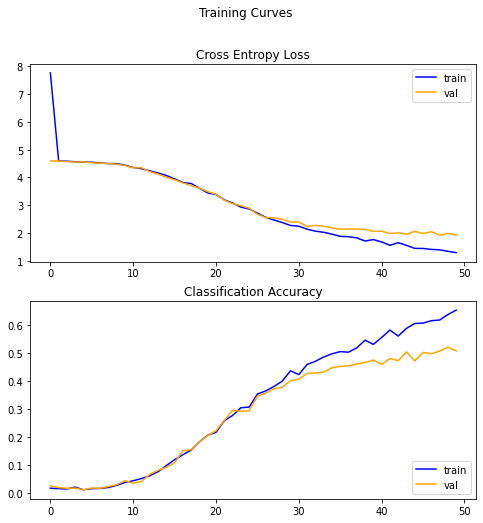


Test set evaluation metrics
10/10 [==============================] - 0s 14ms/step - loss: 1.9111 - accuracy: 0.4977
loss: 1.91
accuracy: 0.50
Train Time:  91.98263764381409
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/hardware_opt/VGG16/assets


In [ ]:
train_and_print_hardware("VGG16")

####VGG19

Epoch 1/50
30/30 [==============================] - 3s 85ms/step - loss: 12.9903 - accuracy: 0.0072 - val_loss: 4.6061 - val_accuracy: 0.0070
Epoch 2/50
30/30 [==============================] - 2s 71ms/step - loss: 4.6047 - accuracy: 0.0142 - val_loss: 4.6046 - val_accuracy: 0.0133
Epoch 3/50
30/30 [==============================] - 2s 70ms/step - loss: 4.6043 - accuracy: 0.0109 - val_loss: 4.6041 - val_accuracy: 0.0156
Epoch 4/50
30/30 [==============================] - 2s 70ms/step - loss: 4.6040 - accuracy: 0.0125 - val_loss: 4.6039 - val_accuracy: 0.0094
Epoch 5/50
30/30 [==============================] - 2s 71ms/step - loss: 4.6036 - accuracy: 0.0084 - val_loss: 4.6034 - val_accuracy: 0.0086
Epoch 6/50
30/30 [==============================] - 2s 71ms/step - loss: 4.6034 - accuracy: 0.0131 - val_loss: 4.6030 - val_accuracy: 0.0109
Epoch 7/50
30/30 [==============================] - 2s 72ms/step - loss: 4.6028 - accuracy: 0.0095 - val_loss: 4.6024 - val_accuracy: 0.0133
Epoch 8/50
3

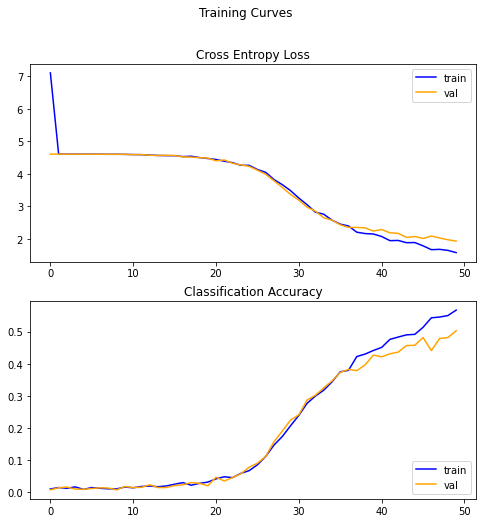


Test set evaluation metrics
10/10 [==============================] - 0s 18ms/step - loss: 1.8658 - accuracy: 0.5117
loss: 1.87
accuracy: 0.51
Train Time:  110.89042234420776
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/hardware_opt/VGG19/assets


In [ ]:
train_and_print_hardware("VGG19")

####Xception

Epoch 1/50
30/30 [==============================] - 14s 344ms/step - loss: 4.6085 - accuracy: 0.0165 - val_loss: 4.6632 - val_accuracy: 0.0258
Epoch 2/50
30/30 [==============================] - 10s 323ms/step - loss: 4.3328 - accuracy: 0.0672 - val_loss: 4.1345 - val_accuracy: 0.1063
Epoch 3/50
30/30 [==============================] - 10s 329ms/step - loss: 3.9758 - accuracy: 0.1658 - val_loss: 3.6350 - val_accuracy: 0.2000
Epoch 4/50
30/30 [==============================] - 10s 334ms/step - loss: 3.5437 - accuracy: 0.2712 - val_loss: 3.2105 - val_accuracy: 0.2758
Epoch 5/50
30/30 [==============================] - 10s 322ms/step - loss: 3.2192 - accuracy: 0.3109 - val_loss: 2.7880 - val_accuracy: 0.3344
Epoch 6/50
30/30 [==============================] - 9s 317ms/step - loss: 2.9217 - accuracy: 0.3839 - val_loss: 2.5580 - val_accuracy: 0.3742
Epoch 7/50
30/30 [==============================] - 9s 316ms/step - loss: 2.6372 - accuracy: 0.4261 - val_loss: 2.3624 - val_accuracy: 0.4281
E

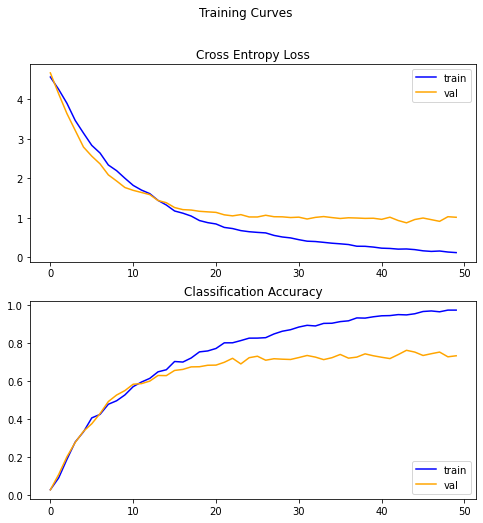


Test set evaluation metrics
10/10 [==============================] - 1s 66ms/step - loss: 0.9649 - accuracy: 0.7461
loss: 0.96
accuracy: 0.75
Train Time:  484.016633272171
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/hardware_opt/Xception/assets


In [ ]:
train_and_print_hardware("Xception")

##Model Optimization - Overfitting
<br>

####Use of Early Stopping, Dropout and Data augmentation
Combined with the hardware optimizations

In [ ]:
sub_path = "model_optimizations/"

In [ ]:
#callbacks
callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta= 0.004)

#dropout - redefine tranfer_learn to include dropout
#!!!! we added layers - expect to see increased time
Dropout = True

def transfer_learn(model):
  model, transfered = load_model(model)
  if not transfered:
    return model
  model.trainable=True
  new_layers = [tf.keras.layers.Dropout(rate = 0.25),
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(256,activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dropout(rate = 0.4),
                tf.keras.layers.Dense(100,activation='softmax')]
  model = tf.keras.Sequential([model]+new_layers)
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  return model


#επαυξηση στα train data
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rotation_range = 10,
                                 horizontal_flip = True,
                                 width_shift_range = 3/32,
                                 height_shift_range = 3/32)

datagen.fit(np.concatenate((x_train,x_val,x_test),axis=0))
temp_x, temp_y = next(datagen.flow(x_train, y_train, batch_size= 8500))
x_train_augm, y_train_augm = np.concatenate((temp_x, x_train),axis=0), np.concatenate((temp_y, y_train),axis=0)

temp_x, temp_y = next(datagen.flow(x_val, y_val, batch_size= 8500))
x_val_augm, y_val_augm = np.concatenate((temp_x, x_val),axis=0), np.concatenate((temp_y, y_val),axis=0)

temp_x, temp_y = next(datagen.flow(x_test, y_test, batch_size= 8500))
x_test_augm, y_test_augm = np.concatenate((temp_x, x_test),axis=0), np.concatenate((temp_y, y_test),axis=0)

#increased augmentation - so much that the NN gets confused
"""

w_shift = 9/32
h_shift = 9/32
rotation_range = 60
shear_range = 0.4
zoom_range = 0.3

datagen_large = ImageDataGenerator(rotation_range = rotation_range,
                                  shear_range = shear_range,
                                  zoom_range = zoom_range,
                                  vertical_flip = True,
                                  horizontal_flip = True,
                                  width_shift_range = w_shift,
                                  height_shift_range = h_shift,
                                  rescale = 1.5)
datagen_large.fit(x_train)
augm_large_x, augm_large_y = next(datagen_large.flow(x_train, y_train, batch_size= 8500))
"""

'\n\nw_shift = 9/32\nh_shift = 9/32\nrotation_range = 60\nshear_range = 0.4\nzoom_range = 0.3\n\ndatagen_large = ImageDataGenerator(rotation_range = rotation_range,\n                                  shear_range = shear_range,\n                                  zoom_range = zoom_range,\n                                  vertical_flip = True,\n                                  horizontal_flip = True,\n                                  width_shift_range = w_shift,\n                                  height_shift_range = h_shift,\n                                  rescale = 1.5)\ndatagen_large.fit(x_train)\naugm_large_x, augm_large_y = next(datagen_large.flow(x_train, y_train, batch_size= 8500))\n'

In [ ]:
write_tfrecords(x_val_augm, y_val_augm, 'val_augm.tfrecords')
write_tfrecords(x_test_augm, y_test_augm, 'test_augm.tfrecords')
write_tfrecords(x_train_augm, y_train_augm, 'train_augm.tfrecords')


def train3(model_name, train_ds, validation_ds, test_ds):
  
  model = transfer_learn(model_name)
  start = time.time()
  model_history =  model.fit(train_ds, epochs=70, steps_per_epoch=30, validation_data=validation_ds, validation_steps=10, callbacks = callbacks)
  duration = time.time() - start
  model_report(model, model_history, test_ds = test_ds)
  print("Train Time: ",duration)
  save_model(model, model_history, duration, model_name)

def train_and_print_model(model):
  train_ds = read_dataset(70, BATCH_SIZE, 'train', model, True)
  validation_ds = read_dataset(70, BATCH_SIZE, 'val', model, True)
  test_ds = read_dataset(70, BATCH_SIZE, 'test', model, True)

  train3(model, train_ds, validation_ds, test_ds)

###Μοντέλα from scratch

####Scratch model 1

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

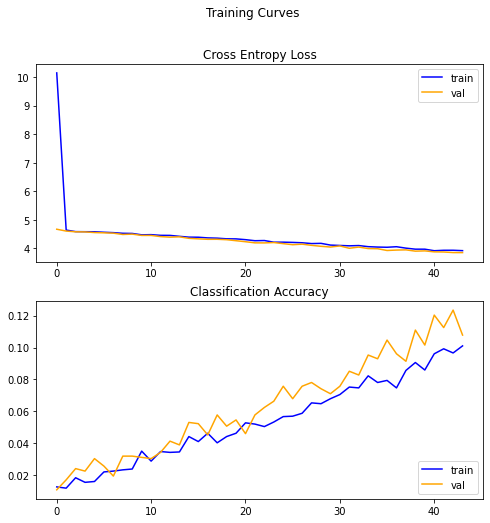


Test set evaluation metrics
10/10 [==============================] - 0s 6ms/step - loss: 3.8436 - accuracy: 0.1164
loss: 3.84
accuracy: 0.12
Train Time:  14.952834844589233
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/Keras Optimization/model_1/assets


In [ ]:
train_and_print_model("model_1")

####Scratch model 2

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 13, 64)        30784     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 4, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

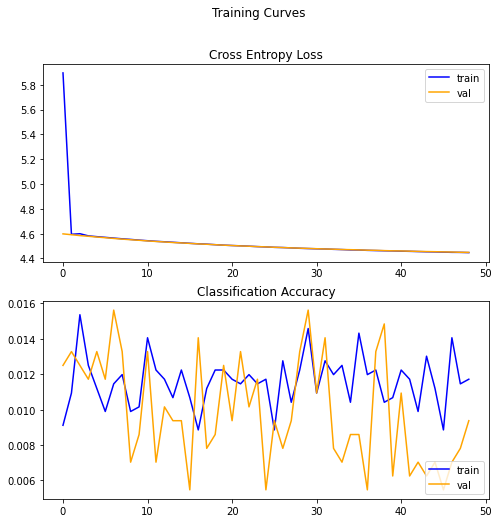


Test set evaluation metrics
10/10 [==============================] - 0s 6ms/step - loss: 4.4471 - accuracy: 0.0125
loss: 4.45
accuracy: 0.01
Train Time:  14.511733293533325
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/Keras Optimization/model_2/assets


In [ ]:
train_and_print_model("model_2")

####Scratch model 3


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 128)      

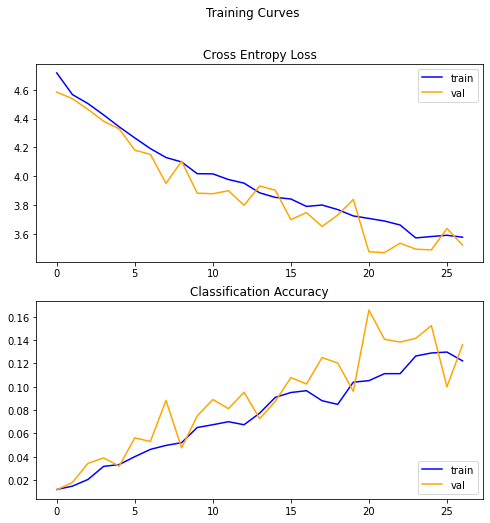


Test set evaluation metrics
10/10 [==============================] - 0s 8ms/step - loss: 3.5446 - accuracy: 0.1477
loss: 3.54
accuracy: 0.15
Train Time:  14.53983473777771
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/Keras Optimization/model_3/assets


In [ ]:
train_and_print_model("model_3")

###Μοντέλα με Transfer Learning

####DenseNet

Epoch 1/70
30/30 [==============================] - 25s 188ms/step - loss: 5.6070 - accuracy: 0.0132 - val_loss: 4.7046 - val_accuracy: 0.0133
Epoch 2/70
30/30 [==============================] - 3s 97ms/step - loss: 5.5041 - accuracy: 0.0129 - val_loss: 4.5365 - val_accuracy: 0.0344
Epoch 3/70
30/30 [==============================] - 3s 98ms/step - loss: 5.1979 - accuracy: 0.0227 - val_loss: 4.4741 - val_accuracy: 0.0445
Epoch 4/70
30/30 [==============================] - 3s 98ms/step - loss: 5.0377 - accuracy: 0.0295 - val_loss: 4.4179 - val_accuracy: 0.0672
Epoch 5/70
30/30 [==============================] - 3s 99ms/step - loss: 4.7745 - accuracy: 0.0425 - val_loss: 4.3248 - val_accuracy: 0.1070
Epoch 6/70
30/30 [==============================] - 3s 99ms/step - loss: 4.6622 - accuracy: 0.0550 - val_loss: 4.2694 - val_accuracy: 0.1063
Epoch 7/70
30/30 [==============================] - 3s 100ms/step - loss: 4.5164 - accuracy: 0.0684 - val_loss: 4.1997 - val_accuracy: 0.1164
Epoch 8/70

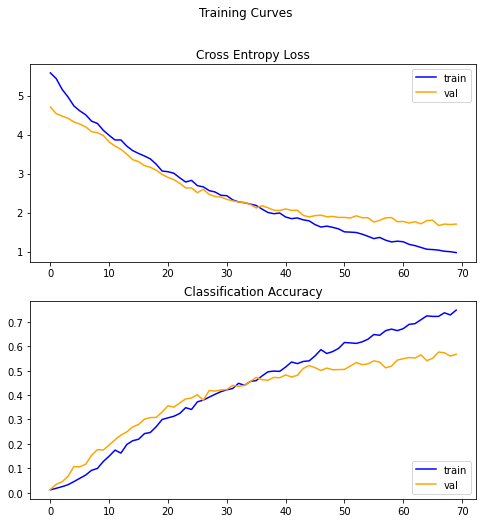


Test set evaluation metrics
10/10 [==============================] - 0s 29ms/step - loss: 1.6293 - accuracy: 0.5852
loss: 1.63
accuracy: 0.59
Train Time:  223.6769618988037
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/Keras Optimization/DenseNet 201/assets


In [ ]:
train_and_print_model("DenseNet 201")

####Inception-ResNet V2

219062272/219055592 [==============================] - 1s 0us/step
Epoch 1/70
30/30 [==============================] - 27s 353ms/step - loss: 5.6799 - accuracy: 0.0127 - val_loss: 5.1026 - val_accuracy: 0.0109
Epoch 2/70
30/30 [==============================] - 8s 262ms/step - loss: 5.4142 - accuracy: 0.0134 - val_loss: 4.6491 - val_accuracy: 0.0219
Epoch 3/70
30/30 [==============================] - 8s 262ms/step - loss: 5.1667 - accuracy: 0.0218 - val_loss: 4.4896 - val_accuracy: 0.0453
Epoch 4/70
30/30 [==============================] - 8s 257ms/step - loss: 4.9239 - accuracy: 0.0328 - val_loss: 4.3558 - val_accuracy: 0.0711
Epoch 5/70
30/30 [==============================] - 8s 257ms/step - loss: 4.8338 - accuracy: 0.0383 - val_loss: 4.2357 - val_accuracy: 0.1023
Epoch 6/70
30/30 [==============================] - 8s 254ms/step - loss: 4.6322 - accuracy: 0.0550 - val_loss: 4.0997 - val_accuracy: 0.1453
Epoch 7/70
30/30 [==============================] - 8s 252ms/step - loss: 4.4816

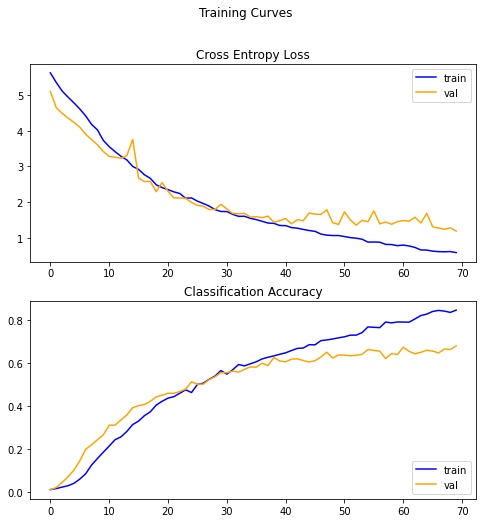


Test set evaluation metrics
10/10 [==============================] - 1s 67ms/step - loss: 1.2574 - accuracy: 0.6656
loss: 1.26
accuracy: 0.67
Train Time:  547.3810324668884
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/Keras Optimization/Inception-ResNet V2/assets


In [ ]:
train_and_print_model("Inception-ResNet V2")

####Inception V3

87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/70
30/30 [==============================] - 18s 202ms/step - loss: 5.5321 - accuracy: 0.0098 - val_loss: 4.6902 - val_accuracy: 0.0141
Epoch 2/70
30/30 [==============================] - 4s 123ms/step - loss: 5.2999 - accuracy: 0.0092 - val_loss: 4.6306 - val_accuracy: 0.0141
Epoch 3/70
30/30 [==============================] - 4s 124ms/step - loss: 5.1381 - accuracy: 0.0201 - val_loss: 4.5636 - val_accuracy: 0.0219
Epoch 4/70
30/30 [==============================] - 4s 126ms/step - loss: 5.0490 - accuracy: 0.0220 - val_loss: 4.5176 - val_accuracy: 0.0250
Epoch 5/70
30/30 [==============================] - 4s 126ms/step - loss: 4.9336 - accuracy: 0.0356 - val_loss: 4.4599 - val_accuracy: 0.0367
Epoch 6/70
30/30 [==============================] - 4s 125ms/step - loss: 4.7853 - accuracy: 0.0244 - val_loss: 4.4011 - val_accuracy: 0.0539
Epoch 7/70
30/30 [==============================] - 4s 125ms/step - loss: 4.7521 -

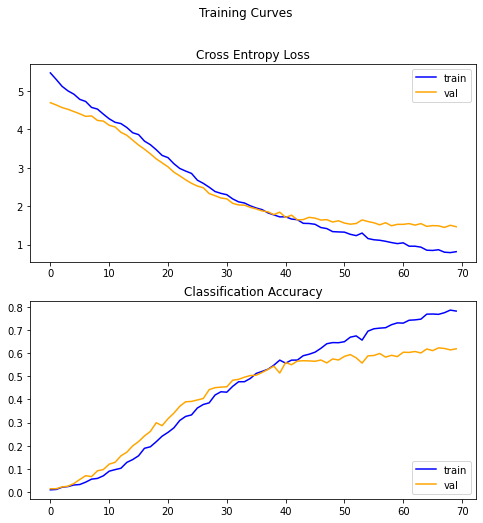


Test set evaluation metrics
10/10 [==============================] - 0s 31ms/step - loss: 1.4229 - accuracy: 0.6344
loss: 1.42
accuracy: 0.63
Train Time:  270.8494482040405
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/Keras Optimization/Inception V3/assets


In [ ]:
train_and_print_model("Inception V3")

####MobileNet v2

Epoch 1/70
30/30 [==============================] - 6s 62ms/step - loss: 5.6739 - accuracy: 0.0076 - val_loss: 4.6103 - val_accuracy: 0.0133
Epoch 2/70
30/30 [==============================] - 1s 27ms/step - loss: 5.5009 - accuracy: 0.0088 - val_loss: 4.6302 - val_accuracy: 0.0148
Epoch 3/70
30/30 [==============================] - 1s 27ms/step - loss: 5.4726 - accuracy: 0.0083 - val_loss: 4.6242 - val_accuracy: 0.0141
Epoch 4/70
30/30 [==============================] - 1s 26ms/step - loss: 5.4327 - accuracy: 0.0173 - val_loss: 4.6535 - val_accuracy: 0.0094
Epoch 5/70
30/30 [==============================] - 1s 27ms/step - loss: 5.3166 - accuracy: 0.0144 - val_loss: 4.6591 - val_accuracy: 0.0086
Epoch 6/70
30/30 [==============================] - 1s 27ms/step - loss: 5.3106 - accuracy: 0.0178 - val_loss: 4.6472 - val_accuracy: 0.0125
Epoch 7/70
30/30 [==============================] - 1s 27ms/step - loss: 5.1978 - accuracy: 0.0173 - val_loss: 4.6608 - val_accuracy: 0.0141
Epoch 8/70
30

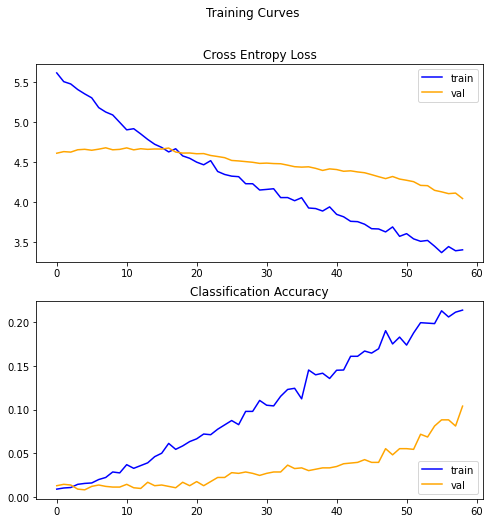


Test set evaluation metrics
10/10 [==============================] - 0s 10ms/step - loss: 4.0194 - accuracy: 0.1055
loss: 4.02
accuracy: 0.11
Train Time:  50.17767834663391
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/Keras Optimization/MobileNet v2/assets


In [ ]:
train_and_print_model("MobileNet v2")

####ResNet v2

234553344/234545216 [==============================] - 2s 0us/step
Epoch 1/70
30/30 [==============================] - 22s 227ms/step - loss: 5.5530 - accuracy: 0.0120 - val_loss: 4.8873 - val_accuracy: 0.0102
Epoch 2/70
30/30 [==============================] - 5s 153ms/step - loss: 5.3663 - accuracy: 0.0100 - val_loss: 4.6368 - val_accuracy: 0.0117
Epoch 3/70
30/30 [==============================] - 5s 154ms/step - loss: 5.2372 - accuracy: 0.0139 - val_loss: 4.6110 - val_accuracy: 0.0125
Epoch 4/70
30/30 [==============================] - 5s 155ms/step - loss: 5.1270 - accuracy: 0.0142 - val_loss: 4.6005 - val_accuracy: 0.0148
Epoch 5/70
30/30 [==============================] - 5s 156ms/step - loss: 5.1235 - accuracy: 0.0111 - val_loss: 4.6050 - val_accuracy: 0.0094
Epoch 6/70
30/30 [==============================] - 5s 157ms/step - loss: 5.0434 - accuracy: 0.0132 - val_loss: 4.9050 - val_accuracy: 0.0102
Epoch 7/70
30/30 [==============================] - 5s 157ms/step - loss: 5.0357

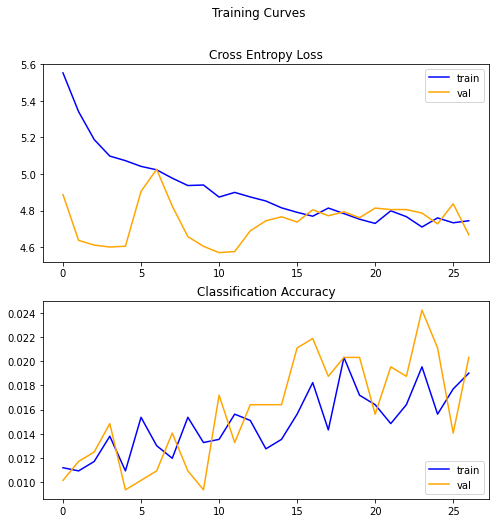


Test set evaluation metrics
10/10 [==============================] - 0s 41ms/step - loss: 4.6281 - accuracy: 0.0203
loss: 4.63
accuracy: 0.02
Train Time:  140.90996479988098
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/Keras Optimization/ResNet v2/assets


In [ ]:
train_and_print_model("ResNet v2")

####VGG16

Epoch 1/70
30/30 [==============================] - 3s 67ms/step - loss: 5.5950 - accuracy: 0.0112 - val_loss: 5.5928 - val_accuracy: 0.0375
Epoch 2/70
30/30 [==============================] - 2s 60ms/step - loss: 5.0382 - accuracy: 0.0361 - val_loss: 5.8425 - val_accuracy: 0.0656
Epoch 3/70
30/30 [==============================] - 2s 60ms/step - loss: 4.7811 - accuracy: 0.0487 - val_loss: 4.0135 - val_accuracy: 0.1141
Epoch 4/70
30/30 [==============================] - 2s 60ms/step - loss: 4.4186 - accuracy: 0.0789 - val_loss: 3.8159 - val_accuracy: 0.1773
Epoch 5/70
30/30 [==============================] - 2s 61ms/step - loss: 4.1605 - accuracy: 0.1052 - val_loss: 3.5049 - val_accuracy: 0.2109
Epoch 6/70
30/30 [==============================] - 2s 61ms/step - loss: 3.9676 - accuracy: 0.1418 - val_loss: 3.3119 - val_accuracy: 0.2500
Epoch 7/70
30/30 [==============================] - 2s 60ms/step - loss: 3.8166 - accuracy: 0.1511 - val_loss: 3.3115 - val_accuracy: 0.2516
Epoch 8/70
30

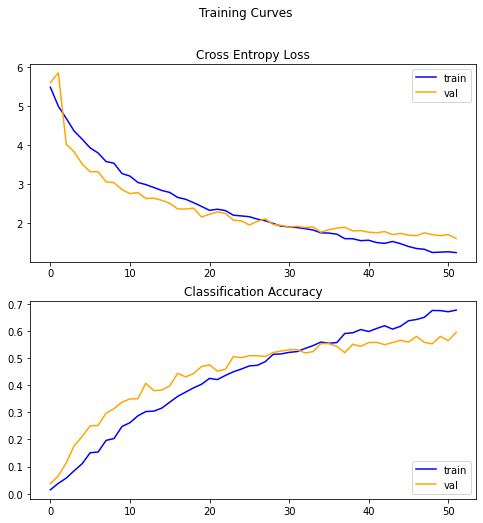


Test set evaluation metrics
10/10 [==============================] - 0s 15ms/step - loss: 1.5229 - accuracy: 0.6102
loss: 1.52
accuracy: 0.61
Train Time:  94.78194832801819
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/Keras Optimization/VGG16/assets


In [ ]:
train_and_print_model("VGG16")

####VGG19

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/70
30/30 [==============================] - 4s 83ms/step - loss: 5.6335 - accuracy: 0.0104 - val_loss: 7.6919 - val_accuracy: 0.0000e+00
Epoch 2/70
30/30 [==============================] - 2s 74ms/step - loss: 5.5674 - accuracy: 0.0077 - val_loss: 5.9729 - val_accuracy: 0.0133
Epoch 3/70
30/30 [==============================] - 2s 75ms/step - loss: 5.4936 - accuracy: 0.0120 - val_loss: 4.9475 - val_accuracy: 0.0180
Epoch 4/70
30/30 [==============================] - 2s 75ms/step - loss: 5.4325 - accuracy: 0.0099 - val_loss: 4.7662 - val_accuracy: 0.0172
Epoch 5/70
30/30 [==============================] - 2s 75ms/step - loss: 5.4170 - accuracy: 0.0097 - val_loss: 4.7350 - val_accuracy: 0.0211
Epoch 6/70
30/30 [==============================] - 2s 75ms/step - loss: 5.2418 - accuracy: 0.0135 - val_loss: 4.8097 - val_accuracy: 0.0289
Epoch 7/70
30/30 [==============================] - 2s 75ms/step - loss: 5.1305 - acc

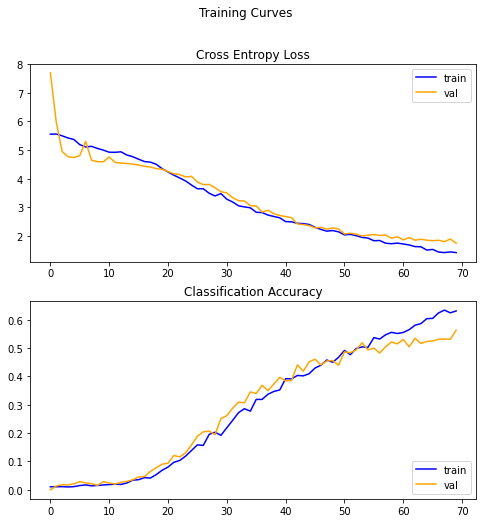


Test set evaluation metrics
10/10 [==============================] - 0s 18ms/step - loss: 1.6894 - accuracy: 0.5695
loss: 1.69
accuracy: 0.57
Train Time:  157.4525167942047
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/Keras Optimization/VGG19/assets


In [ ]:
train_and_print_model("VGG19")

####Xception

83689472/83683744 [==============================] - 1s 0us/step
Epoch 1/70
30/30 [==============================] - 16s 338ms/step - loss: 5.4375 - accuracy: 0.0134 - val_loss: 4.6919 - val_accuracy: 0.0125
Epoch 2/70
30/30 [==============================] - 10s 322ms/step - loss: 5.0099 - accuracy: 0.0234 - val_loss: 4.5046 - val_accuracy: 0.0484
Epoch 3/70
30/30 [==============================] - 10s 325ms/step - loss: 4.6341 - accuracy: 0.0427 - val_loss: 4.4568 - val_accuracy: 0.0758
Epoch 4/70
30/30 [==============================] - 10s 327ms/step - loss: 4.4113 - accuracy: 0.0621 - val_loss: 4.4499 - val_accuracy: 0.0891
Epoch 5/70
30/30 [==============================] - 10s 321ms/step - loss: 4.2741 - accuracy: 0.0811 - val_loss: 4.4129 - val_accuracy: 0.1141
Epoch 6/70
30/30 [==============================] - 9s 317ms/step - loss: 4.1540 - accuracy: 0.1128 - val_loss: 4.3300 - val_accuracy: 0.1531
Epoch 7/70
30/30 [==============================] - 9s 317ms/step - loss: 3.99

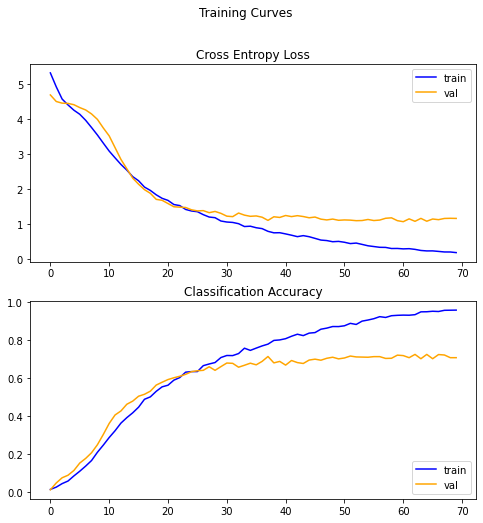


Test set evaluation metrics
10/10 [==============================] - 1s 65ms/step - loss: 1.0466 - accuracy: 0.7437
loss: 1.05
accuracy: 0.74
Train Time:  671.3602986335754
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/Keras Optimization/Xception/assets


In [ ]:
train_and_print_model("Xception")

##Model Optimization - Keras Tuner

In [ ]:
from tensorflow import keras
from kerastuner.tuners import RandomSearch

sub_path = "Keras Optimization/"

def keras_tuner(hp):
    model_type, t = load_model(model_name)
    model = tf.keras.Sequential()
    model.add(model_type)
    model.add(layers.Dropout(rate = hp.Float("dropout",
                                           min_value = 0.1,
                                           max_value = 0.5,
                                           step = 0.1,
                                           default = 0.2)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(units = hp.Int("layers",
                                         min_value = 128,
                                         max_value = 512,
                                         step = 128,
                                         default = 256),
                          activation = hp.Choice("activation",
                                                 values = ["relu","tanh"],
                                                 default = "relu")))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate = hp.Float("dropout_2",
                                           min_value = 0.1,
                                           max_value = 0.5,
                                           step = 0.1,
                                           default = 0.2)))
    """
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(units = hp.Int("layers_2",
                                         min_value = 64,
                                         max_value = 512,
                                         step = 64
                                         default = 256),
                          activation = hp.Choice("activation_2",
                                                 functions = ["relu","tanh"],
                                                 default = "relu")))
    model.add(layers.Dropout(rate = hp.Float("dropout_3",
                                           min_value = 0.1,
                                           max_value = 0.5,
                                           step = 0.05,
                                           default = 0.25))) 
    """

    model.add(layers.Dense(100, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

def train_and_print_keras():
    tuner = RandomSearch(
        keras_tuner,
        objective='val_accuracy',
        max_trials=2,
        executions_per_trial=2)
    train_ds = read_dataset(50, BATCH_SIZE, 'train', model_name, True)
    validation_ds = read_dataset(50, BATCH_SIZE, 'val', model_name, True)
    test_ds = read_dataset(50, BATCH_SIZE, 'test', model_name, True)

    tuner.search(train_ds, epochs = 4, validation_data = validation_ds)
    model = tuner.get_best_models(num_models = 1)
    model = model[0]
    start = time.time()
    model_history =  model.fit(train_ds, epochs=50, steps_per_epoch=30, validation_data=validation_ds, validation_steps=10, callbacks = callbacks)
    duration = time.time() - start
    model_report(model, model_history, test_ds = test_ds)
    print("Train Time: ",duration)
    save_model(model, model_history, duration, model_name)
    print(tuner.get_best_hyperparameters(1)[0])


###DenseNet

In [ ]:
model_name = "DenseNet 201"

train_and_print_keras()

###Inception-ResNet V2

In [ ]:
model_name = "Inception-ResNet V2"

train_and_print_keras()

###Inception V3

In [ ]:
model_name = "Inception V3"

train_and_print_keras()

###MobileNet v2

Trial 2 Complete [00h 35m 14s]
val_accuracy: 0.5395776629447937

Best val_accuracy So Far: 0.5395776629447937
Total elapsed time: 01h 10m 57s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
30/30 [==============================] - 5s 50ms/step - loss: 0.0359 - accuracy: 0.9881 - val_loss: 3.3067 - val_accuracy: 0.5336
Epoch 2/50
30/30 [==============================] - 1s 22ms/step - loss: 0.0526 - accuracy: 0.9873 - val_loss: 3.2540 - val_accuracy: 0.5469
Epoch 3/50
30/30 [==============================] - 1s 22ms/step - loss: 0.0445 - accuracy: 0.9857 - val_loss: 3.2090 - val_accuracy: 0.5430
Epoch 4/50
30/30 [==============================] - 1s 22ms/step - loss: 0.0499 - accuracy: 0.9853 - val_loss: 3.2708 - val_accuracy: 0.5375


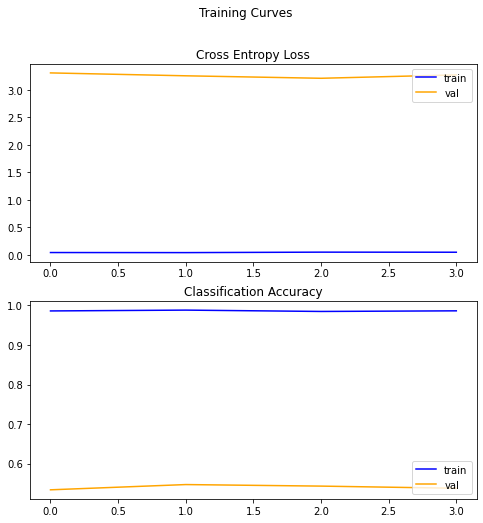


Test set evaluation metrics
10/10 [==============================] - 0s 11ms/step - loss: 3.2540 - accuracy: 0.5469
loss: 3.25
accuracy: 0.55
Train Time:  6.935413599014282
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/Keras Optimization/MobileNet v2/assets


In [ ]:
model_name = "MobileNet v2"

train_and_print_keras()

###ResNet v2

In [ ]:
model_name = "ResNet v2"

train_and_print_keras()

###VGG16

Trial 2 Complete [01h 35m 38s]
val_accuracy: 0.3983224630355835

Best val_accuracy So Far: 0.3983224630355835
Total elapsed time: 03h 07m 41s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
30/30 [==============================] - 3s 66ms/step - loss: 0.0431 - accuracy: 0.9888 - val_loss: 5.1755 - val_accuracy: 0.4141
Epoch 2/50
30/30 [==============================] - 2s 57ms/step - loss: 0.0601 - accuracy: 0.9848 - val_loss: 5.3987 - val_accuracy: 0.4289
Epoch 3/50
30/30 [==============================] - 2s 57ms/step - loss: 0.0510 - accuracy: 0.9884 - val_loss: 5.1730 - val_accuracy: 0.4258
Epoch 4/50
30/30 [==============================] - 2s 57ms/step - loss: 0.0551 - accuracy: 0.9885 - val_loss: 5.1712 - val_accuracy: 0.4359


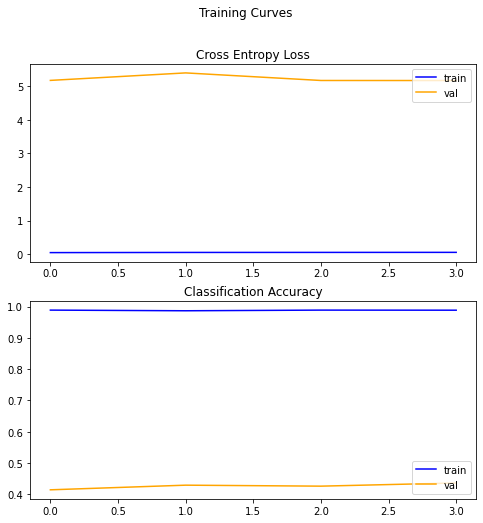


Test set evaluation metrics
10/10 [==============================] - 0s 14ms/step - loss: 5.2465 - accuracy: 0.4477
loss: 5.25
accuracy: 0.45
Train Time:  7.9408509731292725
INFO:tensorflow:Assets written to: /content/drive/My Drive/Neural 3h/Keras Optimization/VGG16/assets


In [ ]:
model_name = "VGG16"

train_and_print_keras()

###VGG19

In [ ]:
model_name = "VGG19"

train_and_print_keras()

###Xception

In [ ]:
model_name = "Xception"

train_and_print_keras()